# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [2]:
# import libraries
import sys
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# import sql library
from sqlalchemy import create_engine

# import nltk libraries
import nltk
nltk.download(['punkt', 'wordnet', 'stopwords'])
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# import sci-kit learn libraries
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# import library to save trained model
import pickle

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\qycli\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\qycli\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\qycli\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [3]:
# load data from database
database_filepath = '../data/DisasterResponse.db'
engine = create_engine('sqlite:///{}'.format(database_filepath))
table_name = os.path.basename(database_filepath).split('.')[0]
df = pd.read_sql_table(table_name, engine)
X = df['message']
Y = df.iloc[:,4:]

### 2. Write a tokenization function to process your text data

In [4]:
def tokenize(text):
    
    # check if there are urls within the text
    url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    detected_urls = re.findall(url_regex,text)
    for url in detected_urls:
        text = text.replace(url,"urlplaceholder")
    
    # remove punctuation
    text = re.sub(r"[^a-zA-Z0-9]"," ",text)
    
    # tokenize the text
    tokens = word_tokenize(text)
    
    # remove stop words
    tokens = [tok for tok in tokens if tok not in stopwords.words("english")]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    
    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)

    return clean_tokens

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [5]:
pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(RandomForestClassifier()))
])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state = 42)
pipeline.fit(X_train, Y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(tokenizer=<function tokenize at 0x00000193F818D160>)),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 MultiOutputClassifier(estimator=RandomForestClassifier()))])

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

#### Test model on training set

In [7]:
# predict on the train set
Y_train_pred = pipeline.predict(X_train)

# classification report on train set
print(classification_report(Y_train.values, Y_train_pred, target_names=Y.columns.values))

# Model accuracy score on train set
Y_train_accuracy = (Y_train_pred == Y_train).mean()
print(Y_train_accuracy)

                        precision    recall  f1-score   support

               related       1.00      1.00      1.00     15103
               request       1.00      1.00      1.00      3504
                 offer       1.00      0.97      0.98       226
           aid_related       1.00      1.00      1.00      8331
          medical_help       1.00      0.99      1.00      1690
      medical_products       1.00      0.99      0.99      1110
     search_and_rescue       1.00      0.99      0.99       706
              security       1.00      0.98      0.99       496
              military       1.00      0.99      0.99       801
           child_alone       0.99      0.95      0.97       141
                 water       1.00      0.99      1.00      1395
                  food       1.00      1.00      1.00      2319
               shelter       1.00      1.00      1.00      1874
              clothing       1.00      0.98      0.99       448
                 money       1.00      

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Test model on test set

hint:
1. Precision: Precision explains how many of the correctly predicted cases actually turned out to be positive. Precision is useful in the cases where False Positive is a higher concern than False Negatives. The importance of Precision is in music or video recommendation systems, e-commerce websites, etc. where wrong results could lead to customer churn and this could be harmful to the business.
2. Recall (Sensitivity): Recall explains how many of the actual positive cases we were able to predict correctly with our model. It is a useful metric in cases where False Negative is of higher concern than False Positive. It is important in medical cases where it doesn’t matter whether we raise a false alarm but the actual positive cases should not go undetected!
3. F1 Score: It gives a combined idea about Precision and Recall metrics. It is maximum when Precision is equal to Recall.
4. AUC-ROC: The Receiver Operator Characteristic (ROC) is a probability curve that plots the TPR(True Positive Rate) against the FPR(False Positive Rate) at various threshold values and separates the ‘signal’ from the ‘noise’.

In [8]:
# predict on the test set
Y_test_pred = pipeline.predict(X_test)

# classification report on test set
print(classification_report(Y_test.values, Y_test_pred, target_names=Y.columns.values))

# Model accuracy score on test set
Y_test_accuracy = (Y_test_pred == Y_test).mean()
print(Y_test_accuracy)

                        precision    recall  f1-score   support

               related       0.83      0.95      0.88      4991
               request       0.79      0.50      0.61      1158
                 offer       0.35      0.15      0.21        80
           aid_related       0.72      0.70      0.71      2717
          medical_help       0.57      0.13      0.22       582
      medical_products       0.56      0.13      0.21       391
     search_and_rescue       0.47      0.15      0.22       206
              security       0.30      0.08      0.13       163
              military       0.41      0.15      0.22       247
           child_alone       0.30      0.28      0.29        47
                 water       0.75      0.43      0.55       465
                  food       0.80      0.56      0.66       792
               shelter       0.74      0.42      0.53       628
              clothing       0.47      0.19      0.27       145
                 money       0.49      

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


when predict on test set, model has lower precision accuracy recall. This indicates overfitting, the precision ranges from 0.3-0.8 averagely.
we may need to try other way improving the model.

### 6. Improve your model
Use grid search to find better parameters. 

Advise to have a gridsearch that runs in adequate time: reduce complexity by using 2-3 parameters with 2-3 values in each

In [18]:
# specify parameters for grid search
# Reduce cv=2 instead of default cv=5 
# Use verbose=2 or 3 to know that the process is running

rfc_params = {'clf__estimator__n_estimators':[100,200],
              'clf__estimator__max_depth':[5]}

# create grid search object
grid_rfc = GridSearchCV(rfc_pipe, param_grid=rfc_params, cv=3, verbose=3)

It takes a very long time to fit the cv into the train set

In [19]:
grid_rfc.fit(X_train,y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV 1/3] END clf__estimator__max_depth=5, clf__estimator__n_estimators=100;, score=0.197 total time= 4.2min
[CV 2/3] END clf__estimator__max_depth=5, clf__estimator__n_estimators=100;, score=0.205 total time= 4.1min
[CV 3/3] END clf__estimator__max_depth=5, clf__estimator__n_estimators=100;, score=0.200 total time= 4.1min
[CV 1/3] END clf__estimator__max_depth=5, clf__estimator__n_estimators=200;, score=0.197 total time= 4.6min
[CV 2/3] END clf__estimator__max_depth=5, clf__estimator__n_estimators=200;, score=0.205 total time= 4.9min
[CV 3/3] END clf__estimator__max_depth=5, clf__estimator__n_estimators=200;, score=0.200 total time= 4.6min


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(tokenizer=<function tokenize at 0x00000249DAE4C430>)),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf',
                                        MultiOutputClassifier(estimator=RandomForestClassifier()))]),
             param_grid={'clf__estimator__max_depth': [5],
                         'clf__estimator__n_estimators': [100, 200]},
             verbose=3)

In [20]:
grid_rfc.best_params_

{'clf__estimator__max_depth': 5, 'clf__estimator__n_estimators': 200}

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [21]:
y_gridrfc_trainpred = grid_rfc.predict(X_train)
y_gridrfc_testpred = grid_rfc.predict(X_test)

In [22]:
# classification report on train set
print('Grid rfc Train Scores')
print(classification_report(y_train.values, y_gridrfc_trainpred, target_names=y.columns.values))
print('\n')

# classification report on test set
print('Grid rfc Test Scores')
print(classification_report(y_test.values, y_gridrfc_testpred, target_names=y.columns.values))
print('\n')

# accuracy score on test set
print('GridSearch rfc Accuracy')
gridrfc_test_accuracy = (y_gridrfc_testpred == y_test).mean()
print(gridrfc_test_accuracy)

Grid rfc Train Scores
                        precision    recall  f1-score   support

               related       0.77      1.00      0.87     15061
               request       0.00      0.00      0.00      3362
                 offer       0.00      0.00      0.00        96
           aid_related       1.00      0.01      0.02      8146
          medical_help       1.00      0.00      0.00      1547
      medical_products       0.00      0.00      0.00       973
     search_and_rescue       0.00      0.00      0.00       562
              security       0.00      0.00      0.00       377
              military       0.00      0.00      0.00       677
                 water       1.00      0.00      0.00      1269
                  food       0.00      0.00      0.00      2226
               shelter       1.00      0.00      0.00      1726
              clothing       0.00      0.00      0.00       313
                 money       0.00      0.00      0.00       448
        missing_p

In [23]:
# compare with rfc without gridsearch tuning
gridrfc_test_accuracy - rfc_test_accuracy

related                  -0.053250
request                  -0.065151
offer                     0.000000
aid_related              -0.194233
medical_help             -0.001831
medical_products         -0.003662
search_and_rescue        -0.001221
security                  0.000000
military                 -0.001678
water                    -0.020598
food                     -0.050809
shelter                  -0.026701
clothing                 -0.001526
money                    -0.000458
missing_people            0.000000
refugees                 -0.000153
death                    -0.007019
other_aid                -0.000305
infrastructure_related    0.000610
transport                -0.001526
buildings                -0.003814
electricity              -0.000458
tools                     0.000000
hospitals                 0.000000
shops                     0.000000
aid_centers               0.000000
other_infrastructure      0.000000
weather_related          -0.161123
floods              

It doesn't seem to have a big improvement with parameters tuning. More categories score very low

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

### 8a. Other machine learning algorithms

1. Decision Tree
2. KNN

Run both with and without GridSearch, then compare to the first guess model (random forest) 

**A. With GridSearch**

A1. Decision Tree

In [24]:
tree_pipe = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(DecisionTreeClassifier()))
])

In [25]:
tree_pipe.get_params()

{'memory': None,
 'steps': [('vect',
   CountVectorizer(tokenizer=<function tokenize at 0x00000249DAE4C430>)),
  ('tfidf', TfidfTransformer()),
  ('clf', MultiOutputClassifier(estimator=DecisionTreeClassifier()))],
 'verbose': False,
 'vect': CountVectorizer(tokenizer=<function tokenize at 0x00000249DAE4C430>),
 'tfidf': TfidfTransformer(),
 'clf': MultiOutputClassifier(estimator=DecisionTreeClassifier()),
 'vect__analyzer': 'word',
 'vect__binary': False,
 'vect__decode_error': 'strict',
 'vect__dtype': numpy.int64,
 'vect__encoding': 'utf-8',
 'vect__input': 'content',
 'vect__lowercase': True,
 'vect__max_df': 1.0,
 'vect__max_features': None,
 'vect__min_df': 1,
 'vect__ngram_range': (1, 1),
 'vect__preprocessor': None,
 'vect__stop_words': None,
 'vect__strip_accents': None,
 'vect__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vect__tokenizer': <function __main__.tokenize(text)>,
 'vect__vocabulary': None,
 'tfidf__norm': 'l2',
 'tfidf__smooth_idf': True,
 'tfidf__sublinear_tf': False,


In [26]:
tree_params = {'clf__estimator__max_depth':[2,5,10]}

# create grid search object
grid_tree = GridSearchCV(tree_pipe, param_grid=tree_params, cv=3, verbose=3)

In [27]:
grid_tree.fit(X_train,y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 1/3] END .......clf__estimator__max_depth=2;, score=0.193 total time= 3.9min
[CV 2/3] END .......clf__estimator__max_depth=2;, score=0.208 total time= 3.7min
[CV 3/3] END .......clf__estimator__max_depth=2;, score=0.190 total time= 3.6min
[CV 1/3] END .......clf__estimator__max_depth=5;, score=0.224 total time= 3.7min
[CV 2/3] END .......clf__estimator__max_depth=5;, score=0.232 total time= 4.0min
[CV 3/3] END .......clf__estimator__max_depth=5;, score=0.220 total time= 3.9min
[CV 1/3] END ......clf__estimator__max_depth=10;, score=0.226 total time= 4.4min
[CV 2/3] END ......clf__estimator__max_depth=10;, score=0.231 total time= 4.3min
[CV 3/3] END ......clf__estimator__max_depth=10;, score=0.219 total time= 4.0min


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(tokenizer=<function tokenize at 0x00000249DAE4C430>)),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf',
                                        MultiOutputClassifier(estimator=DecisionTreeClassifier()))]),
             param_grid={'clf__estimator__max_depth': [2, 5, 10]}, verbose=3)

In [28]:
grid_tree.best_params_

{'clf__estimator__max_depth': 5}

In [29]:
y_gridtree_testpred = grid_tree.predict(X_test)

In [30]:
# classification report on test set
print('Grid tree Test Scores')
print(classification_report(y_test.values, y_gridtree_testpred, target_names=y.columns.values))
print('\n')

# accuracy score on test set
print('Grid tree Accuracy')
gridtree_test_accuracy = (y_gridtree_testpred == y_test).mean()
print(gridtree_test_accuracy)

Grid tree Test Scores
                        precision    recall  f1-score   support

               related       0.79      0.97      0.87      5032
               request       0.78      0.37      0.50      1112
                 offer       0.20      0.05      0.07        22
           aid_related       0.71      0.47      0.56      2714
          medical_help       0.62      0.22      0.33       537
      medical_products       0.70      0.29      0.41       340
     search_and_rescue       0.60      0.25      0.35       162
              security       0.50      0.01      0.02        94
              military       0.49      0.22      0.31       183
                 water       0.74      0.56      0.64       403
                  food       0.76      0.79      0.78       697
               shelter       0.79      0.54      0.64       588
              clothing       0.64      0.51      0.57        92
                 money       0.54      0.26      0.35       156
        missing_p

A2. KNN Algorithms

In [31]:
knn_pipe = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(KNeighborsClassifier()))
])

In [32]:
knn_pipe.get_params()

{'memory': None,
 'steps': [('vect',
   CountVectorizer(tokenizer=<function tokenize at 0x00000249DAE4C430>)),
  ('tfidf', TfidfTransformer()),
  ('clf', MultiOutputClassifier(estimator=KNeighborsClassifier()))],
 'verbose': False,
 'vect': CountVectorizer(tokenizer=<function tokenize at 0x00000249DAE4C430>),
 'tfidf': TfidfTransformer(),
 'clf': MultiOutputClassifier(estimator=KNeighborsClassifier()),
 'vect__analyzer': 'word',
 'vect__binary': False,
 'vect__decode_error': 'strict',
 'vect__dtype': numpy.int64,
 'vect__encoding': 'utf-8',
 'vect__input': 'content',
 'vect__lowercase': True,
 'vect__max_df': 1.0,
 'vect__max_features': None,
 'vect__min_df': 1,
 'vect__ngram_range': (1, 1),
 'vect__preprocessor': None,
 'vect__stop_words': None,
 'vect__strip_accents': None,
 'vect__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vect__tokenizer': <function __main__.tokenize(text)>,
 'vect__vocabulary': None,
 'tfidf__norm': 'l2',
 'tfidf__smooth_idf': True,
 'tfidf__sublinear_tf': False,
 'tf

In [33]:
knn_params = {'clf__estimator__n_neighbors': [15,20,29]}

grid_knn = GridSearchCV(knn_pipe, param_grid=knn_params, cv=3, verbose=3)

In [34]:
grid_knn.fit(X_train,y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 1/3] END ....clf__estimator__n_neighbors=15;, score=0.226 total time= 6.7min
[CV 2/3] END ....clf__estimator__n_neighbors=15;, score=0.232 total time= 6.6min
[CV 3/3] END ....clf__estimator__n_neighbors=15;, score=0.233 total time= 6.5min
[CV 1/3] END ....clf__estimator__n_neighbors=20;, score=0.238 total time= 6.2min
[CV 2/3] END ....clf__estimator__n_neighbors=20;, score=0.236 total time= 6.1min
[CV 3/3] END ....clf__estimator__n_neighbors=20;, score=0.239 total time= 5.9min
[CV 1/3] END ....clf__estimator__n_neighbors=29;, score=0.229 total time= 5.8min
[CV 2/3] END ....clf__estimator__n_neighbors=29;, score=0.221 total time= 5.3min
[CV 3/3] END ....clf__estimator__n_neighbors=29;, score=0.228 total time= 5.4min


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(tokenizer=<function tokenize at 0x00000249DAE4C430>)),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf',
                                        MultiOutputClassifier(estimator=KNeighborsClassifier()))]),
             param_grid={'clf__estimator__n_neighbors': [15, 20, 29]},
             verbose=3)

In [35]:
grid_knn.best_params_

{'clf__estimator__n_neighbors': 20}

In [36]:
y_gridknn_testpred = grid_knn.predict(X_test)

In [37]:
# classification report on test set
print('Grid KNN Test Scores')
print(classification_report(y_test.values, y_gridknn_testpred, target_names=y.columns.values))
print('\n')

# accuracy score on test set
print('Grid KNN Accuracy')
gridknn_test_accuracy = (y_gridknn_testpred == y_test).mean()
print(gridknn_test_accuracy)

Grid KNN Test Scores
                        precision    recall  f1-score   support

               related       0.83      0.95      0.88      5032
               request       0.81      0.43      0.57      1112
                 offer       0.00      0.00      0.00        22
           aid_related       0.77      0.43      0.55      2714
          medical_help       0.46      0.02      0.04       537
      medical_products       0.71      0.06      0.12       340
     search_and_rescue       1.00      0.01      0.02       162
              security       0.00      0.00      0.00        94
              military       0.55      0.03      0.06       183
                 water       0.88      0.16      0.27       403
                  food       0.82      0.27      0.41       697
               shelter       0.70      0.11      0.19       588
              clothing       0.70      0.08      0.14        92
                 money       0.50      0.01      0.01       156
        missing_pe

**B. Without GridSearch**

B1. Decision Tree

In [38]:
tree_pipe.fit(X_train,y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(tokenizer=<function tokenize at 0x00000249DAE4C430>)),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 MultiOutputClassifier(estimator=DecisionTreeClassifier()))])

In [39]:
y_tree_pred = tree_pipe.predict(X_test)

In [40]:
tree_accuracy = (y_tree_pred == y_test).mean()

B2. KNN

In [41]:
knn_pipe.fit(X_train,y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(tokenizer=<function tokenize at 0x00000249DAE4C430>)),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 MultiOutputClassifier(estimator=KNeighborsClassifier()))])

In [42]:
y_knn_pred = knn_pipe.predict(X_test)

In [43]:
knn_accuracy = (y_knn_pred == y_test).mean()

**C. Accuracy comparison**

In [59]:
# model names
model_names = ['rfc','dtree','knn','grid rfc','grid dtree','grid knn']

# concatenate accuracry scores
accuracy_df = pd.concat([rfc_test_accuracy, tree_accuracy, knn_accuracy,
                         gridrfc_test_accuracy,gridtree_test_accuracy,gridknn_test_accuracy],axis=1)
accuracy_df.columns=model_names

print('Models Accuracy Score Comparison')
accuracy_df

Models Accuracy Score Comparison


,rfc,dtree,knn,grid rfc,grid dtree,grid knn
related,0.821025,0.767775,0.790815,0.767775,0.783033,0.807141
request,0.895484,0.847727,0.865273,0.830333,0.874733,0.887244
offer,0.996643,0.993439,0.996643,0.996643,0.996186,0.996643
aid_related,0.783186,0.712695,0.649527,0.588953,0.699878,0.710711
medical_help,0.919896,0.901587,0.918981,0.918065,0.925389,0.917760
medical_products,0.951785,0.939579,0.948886,0.948123,0.956820,0.950107
search_and_rescue,0.976503,0.958193,0.975893,0.975282,0.977266,0.975587
security,0.985658,0.971926,0.985505,0.985658,0.985658,0.985658
military,0.973756,0.968111,0.973299,0.972078,0.971926,0.972231
water,0.959109,0.955752,0.942478,0.938511,0.961092,0.946750


In [60]:
accuracy_df.loc['Average']=avg_score
accuracy_df

,rfc,dtree,knn,grid rfc,grid dtree,grid knn
related,0.821025,0.767775,0.790815,0.767775,0.783033,0.807141
request,0.895484,0.847727,0.865273,0.830333,0.874733,0.887244
offer,0.996643,0.993439,0.996643,0.996643,0.996186,0.996643
aid_related,0.783186,0.712695,0.649527,0.588953,0.699878,0.710711
medical_help,0.919896,0.901587,0.918981,0.918065,0.925389,0.917760
medical_products,0.951785,0.939579,0.948886,0.948123,0.956820,0.950107
search_and_rescue,0.976503,0.958193,0.975893,0.975282,0.977266,0.975587
security,0.985658,0.971926,0.985505,0.985658,0.985658,0.985658
military,0.973756,0.968111,0.973299,0.972078,0.971926,0.972231
water,0.959109,0.955752,0.942478,0.938511,0.961092,0.946750


In [61]:
to_graph = accuracy_df.to_dict()

Text(0, 0.5, 'Accuracy rate')

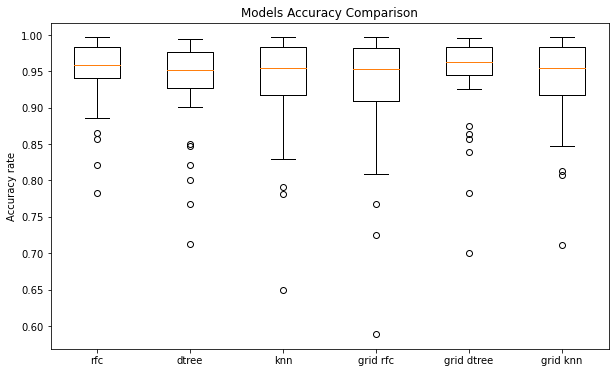

In [63]:
fig, ax = plt.subplots(figsize=(10,6))
ax.boxplot(accuracy_df.values)
ax.set_xticklabels(['rfc','dtree','knn','grid rfc','grid dtree','grid knn'])

plt.title('Models Accuracy Comparison')
plt.ylabel('Accuracy rate')

### Regardless the implement of GridSearch, all models don't perform as well as the original Random Forest

### 8b. Use Custom Transformer 

1. Create a custom estimator that identify the buzzwords relates to Disaster
2. Apply the feature union in above pipleline using rfc as the estimator
3. Choose to apply of rfc only

In [64]:
class DisasterWordExtractor(BaseEstimator, TransformerMixin):

    def disaster_words(self, text):
        """
        INPUT: text - string, raw text data
        OUTPUT: bool -bool object, True or False
        """
        # list of words that are commonly used during a disaster event
        disaster_words = ['food','hunger','hungry','starving','water','drink','eat','thirsty',
                 'need','hospital','medicine','medical','ill','pain','disease','injured','falling',
                 'wound','blood','dying','death','dead','aid','help','assistance','cloth','cold','wet','shelter',
                 'hurricane','earthquake','flood','whirlpool','live','alive','child','people','shortage','blocked',
                 'trap','rob','gas','pregnant','baby','cry','fire','blizard','freezing','blackout','drought',
                 'hailstorm','heat','pressure','lightning','tornado','tsunami']
        
        # lemmatize the buzzwords
        lemmatized_words = [WordNetLemmatizer().lemmatize(w, pos='v') for w in disaster_words]
        # Get the stem words of each word in lemmatized_words 
        stem_disaster_words = [PorterStemmer().stem(w) for w in lemmatized_words]
        
        # tokenize the input text
        clean_tokens = tokenize(text)
        for token in clean_tokens:
            if token in stem_disaster_words:
                return True
        return False
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        X_disaster_words = pd.Series(X).apply(self.disaster_words)
        return pd.DataFrame(X_disaster_words)

In [65]:
word_pipe = Pipeline([
    ('features',FeatureUnion([
        ('text_pipeline',Pipeline([
            ('vect',CountVectorizer(tokenizer=tokenize)),
            ('tfidf',TfidfTransformer())
        ])),
        ('disaster_words',DisasterWordExtractor())
    ])),
    ('clf',MultiOutputClassifier(RandomForestClassifier()))
])

**A. With GridSearch**

In [66]:
word_pipe.fit(X_train,y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('text_pipeline',
                                                 Pipeline(steps=[('vect',
                                                                  CountVectorizer(tokenizer=<function tokenize at 0x00000249DAE4C430>)),
                                                                 ('tfidf',
                                                                  TfidfTransformer())])),
                                                ('disaster_words',
                                                 DisasterWordExtractor())])),
                ('clf',
                 MultiOutputClassifier(estimator=RandomForestClassifier()))])

In [67]:
y_wordpipe_pred= word_pipe.predict(X_test)

In [68]:
# classification report on test set
print('With Disaster Word Extractor Test Scores')
print(classification_report(y_test.values, y_wordpipe_pred, target_names=y.columns.values))
print('\n')

# accuracy score on test set
print('With Disaster Word Extractor Accuracy')
wordpipe_test_accuracy = (y_wordpipe_pred == y_test).mean()
wordpipe_test_accuracy.mean()

With Disaster Word Extractor Test Scores
                        precision    recall  f1-score   support

               related       0.84      0.95      0.89      5032
               request       0.81      0.51      0.63      1112
                 offer       0.00      0.00      0.00        22
           aid_related       0.76      0.70      0.73      2714
          medical_help       0.73      0.08      0.14       537
      medical_products       0.75      0.09      0.16       340
     search_and_rescue       0.69      0.06      0.10       162
              security       0.50      0.01      0.02        94
              military       0.64      0.10      0.17       183
                 water       0.87      0.41      0.56       403
                  food       0.81      0.59      0.68       697
               shelter       0.84      0.36      0.51       588
              clothing       0.80      0.09      0.16        92
                 money       1.00      0.03      0.05       15

0.9476742665329788

*With Disaster Word Extractor Custom Estimator, the accuracy score is still similar as 0.947879 (rfc)*

**B. Without GridSearch**

In [69]:
rfc_params = {'clf__estimator__n_estimators':[100,200],
              'clf__estimator__max_depth':[5]}

# create grid search object
grid_wordpipe = GridSearchCV(word_pipe, param_grid=rfc_params, cv=3, verbose=3)

In [70]:
grid_wordpipe.fit(X_train,y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV 1/3] END clf__estimator__max_depth=5, clf__estimator__n_estimators=100;, score=0.197 total time= 8.6min
[CV 2/3] END clf__estimator__max_depth=5, clf__estimator__n_estimators=100;, score=0.205 total time= 8.2min
[CV 3/3] END clf__estimator__max_depth=5, clf__estimator__n_estimators=100;, score=0.200 total time= 7.4min
[CV 1/3] END clf__estimator__max_depth=5, clf__estimator__n_estimators=200;, score=0.197 total time= 7.5min
[CV 2/3] END clf__estimator__max_depth=5, clf__estimator__n_estimators=200;, score=0.205 total time= 7.4min
[CV 3/3] END clf__estimator__max_depth=5, clf__estimator__n_estimators=200;, score=0.200 total time= 7.4min


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('features',
                                        FeatureUnion(transformer_list=[('text_pipeline',
                                                                        Pipeline(steps=[('vect',
                                                                                         CountVectorizer(tokenizer=<function tokenize at 0x00000249DAE4C430>)),
                                                                                        ('tfidf',
                                                                                         TfidfTransformer())])),
                                                                       ('disaster_words',
                                                                        DisasterWordExtractor())])),
                                       ('clf',
                                        MultiOutputClassifier(estimator=RandomForestClassifier()))]),
             param_grid={'clf__e

In [71]:
grid_wordpipe.best_params_

{'clf__estimator__max_depth': 5, 'clf__estimator__n_estimators': 200}

In [72]:
y_grid_wordpipe_pred= grid_wordpipe.predict(X_test)

In [73]:
# classification report on test set
print('With Disaster Word Extractor Test Scores')
print(classification_report(y_test.values, y_grid_wordpipe_pred, target_names=y.columns.values))
print('\n')

# accuracy score on test set
print('With Disaster Word Extractor Accuracy')
grid_wordpipe_test_accuracy = (y_grid_wordpipe_pred == y_test).mean()
grid_wordpipe_test_accuracy.mean()

With Disaster Word Extractor Test Scores
                        precision    recall  f1-score   support

               related       0.77      1.00      0.87      5032
               request       0.00      0.00      0.00      1112
                 offer       0.00      0.00      0.00        22
           aid_related       0.95      0.01      0.01      2714
          medical_help       0.00      0.00      0.00       537
      medical_products       0.00      0.00      0.00       340
     search_and_rescue       0.00      0.00      0.00       162
              security       0.00      0.00      0.00        94
              military       0.00      0.00      0.00       183
                 water       0.00      0.00      0.00       403
                  food       0.00      0.00      0.00       697
               shelter       0.00      0.00      0.00       588
              clothing       0.00      0.00      0.00        92
                 money       0.00      0.00      0.00       15

0.9255634508914949

In [74]:
# model names
model2_names = ['rfc','rfc+buzzwords','grid rfc','grid rfc+buzzwords']

# concatenate accuracry scores
accuracy2_df = pd.concat([rfc_test_accuracy, wordpipe_test_accuracy,
                         gridrfc_test_accuracy,grid_wordpipe_test_accuracy],axis=1)
accuracy2_df.columns=model2_names

avg_score2 = []
for model in model2_names:
    avg_score2.append(accuracy2_df[model].mean())
    
accuracy2_df.loc['Average']=avg_score2
    
print('Models with Buzzwords Feature Accuracy Score Comparison')
accuracy2_df

Models with Buzzwords Feature Accuracy Score Comparison


,rfc,rfc+buzzwords,grid rfc,grid rfc+buzzwords
related,0.821025,0.820110,0.767775,0.767775
request,0.895484,0.896552,0.830333,0.830333
offer,0.996643,0.996643,0.996643,0.996643
aid_related,0.783186,0.781660,0.588953,0.588496
medical_help,0.919896,0.922185,0.918065,0.918065
medical_products,0.951785,0.951175,0.948123,0.948123
search_and_rescue,0.976503,0.976045,0.975282,0.975282
security,0.985658,0.985658,0.985658,0.985658
military,0.973756,0.973299,0.972078,0.972078
water,0.959109,0.960024,0.938511,0.938511


Very interesting that the accuracy is lower with GridSearch

#### The Data is also highly imbalanced which is observed in Classification Reports

-> I'm going to use Random Forest with Feature union WITHOUT gridsearch for the final ML model

### 9. Export your model as a pickle file

In [75]:
import pickle

In [77]:
# save the model to disk
pickle.dump(grid_wordpipe, open('classifier.pickle','wb'))

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.